<a href="https://colab.research.google.com/github/Oliver1107/Fraud-Detection/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis and Prediction of Fraud

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("umuttuygurr/e-commerce-fraud-detection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'e-commerce-fraud-detection-dataset' dataset.
Path to dataset files: /kaggle/input/e-commerce-fraud-detection-dataset


In [ ]:
# Find and load dataset

import os

path = path + '/' + os.listdir(path)[0]

In [ ]:
path

'/kaggle/input/e-commerce-fraud-detection-dataset/transactions.csv'

In [ ]:
# Import standard packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(path)

In [ ]:
# Explore dataset and feature types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [ ]:
df.isnull().any()

,0
transaction_id,False
user_id,False
account_age_days,False
total_transactions_user,False
avg_amount_user,False
amount,False
country,False
bin_country,False
channel,False
merchant_category,False


No null values in the dataset

array([[<Axes: title={'center': 'transaction_id'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'account_age_days'}>],
       [<Axes: title={'center': 'total_transactions_user'}>,
        <Axes: title={'center': 'avg_amount_user'}>,
        <Axes: title={'center': 'amount'}>],
       [<Axes: title={'center': 'promo_used'}>,
        <Axes: title={'center': 'avs_match'}>,
        <Axes: title={'center': 'cvv_result'}>],
       [<Axes: title={'center': 'three_ds_flag'}>,
        <Axes: title={'center': 'shipping_distance_km'}>,
        <Axes: title={'center': 'is_fraud'}>]], dtype=object)

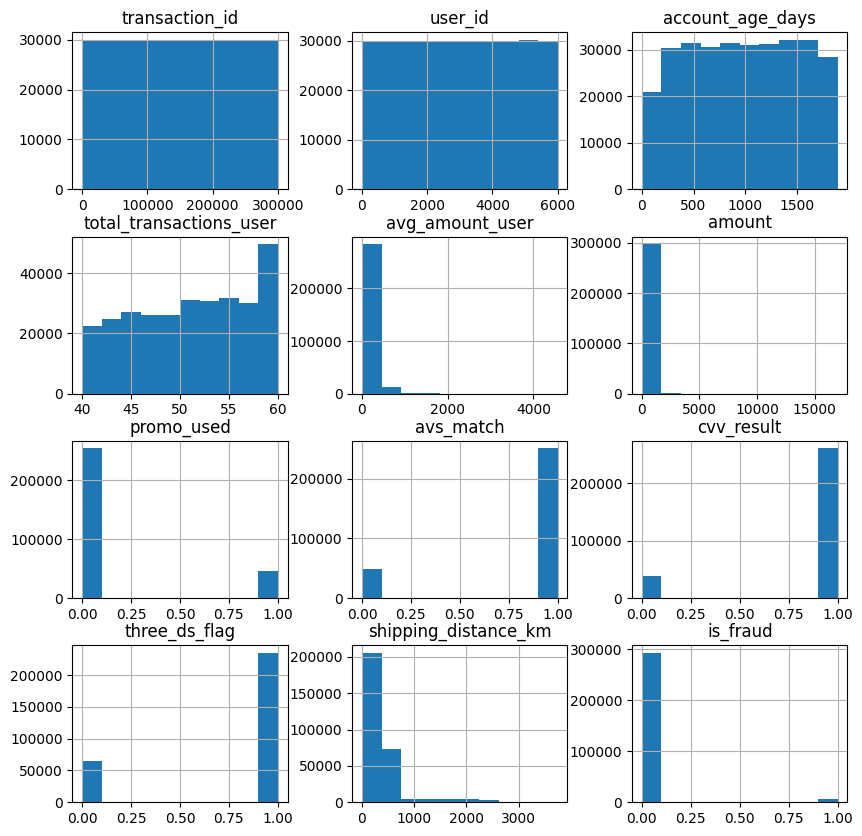

In [ ]:
# Show distribution of numerical features

df.hist(figsize=(10,10))

There appears to be a large imbalance of our target class

In [ ]:
# Check value counts of our target class

df['is_fraud'].value_counts()

,count
is_fraud,
0,293083
1,6612


In [ ]:
# Correct imbalance by sampling from the larger class

balanced_df = pd.concat([df[df['is_fraud'] == 0].sample(7000, ignore_index=True), df[df['is_fraud'] == 1]])

array([[<Axes: title={'center': 'transaction_id'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'account_age_days'}>],
       [<Axes: title={'center': 'total_transactions_user'}>,
        <Axes: title={'center': 'avg_amount_user'}>,
        <Axes: title={'center': 'amount'}>],
       [<Axes: title={'center': 'promo_used'}>,
        <Axes: title={'center': 'avs_match'}>,
        <Axes: title={'center': 'cvv_result'}>],
       [<Axes: title={'center': 'three_ds_flag'}>,
        <Axes: title={'center': 'shipping_distance_km'}>,
        <Axes: title={'center': 'is_fraud'}>]], dtype=object)

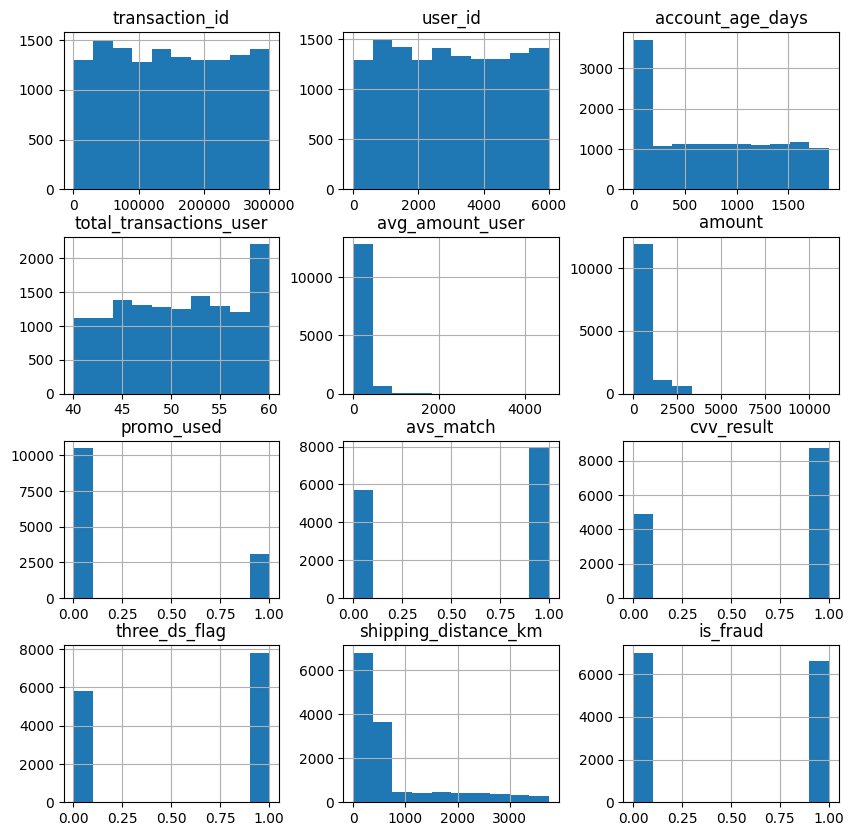

In [ ]:
balanced_df.hist(figsize=(10,10))

Dataset is now balanced

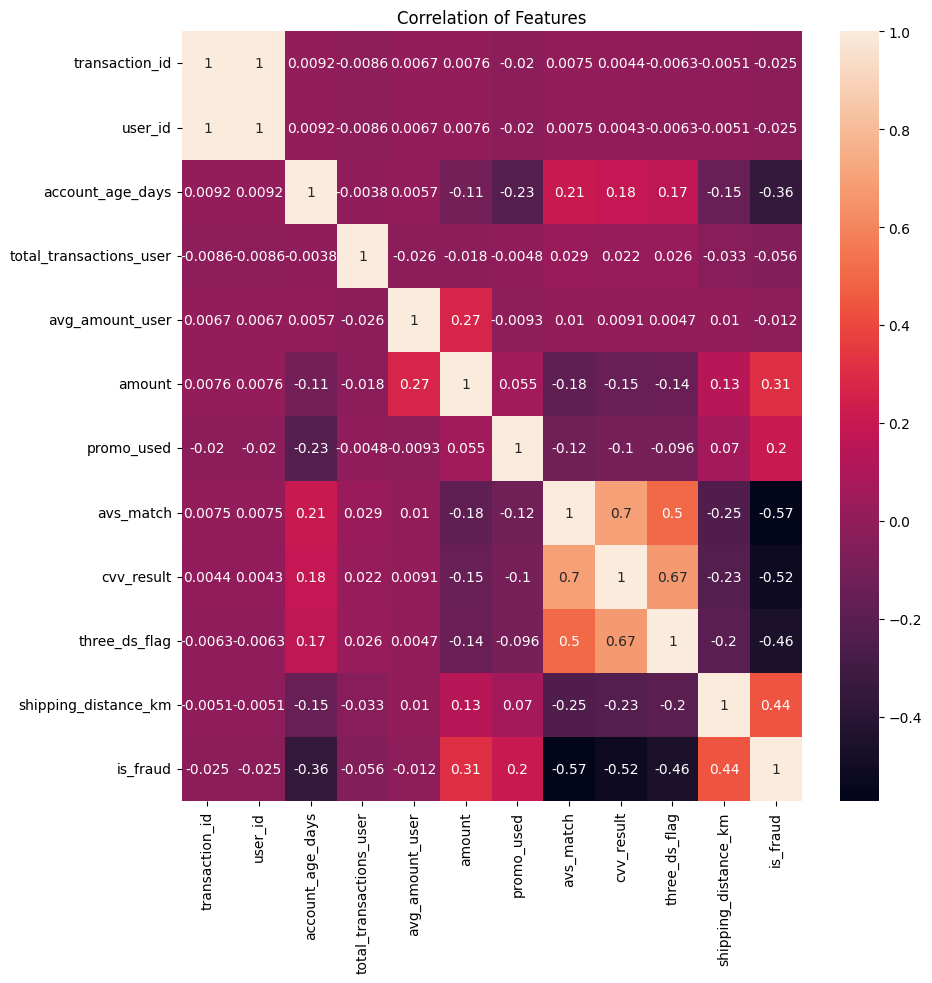

In [ ]:
# Show correlation of features to eachother

plt.figure(figsize=(10,10))

sns.heatmap(balanced_df.corr(numeric_only=True), annot=True)
plt.title('Correlation of Features')
plt.show()

ID, total transactions and average amount have very low correlation with target class

In [ ]:
# Drop unnecessary features

balanced_df = balanced_df.drop(['transaction_id', 'user_id', 'total_transactions_user', 'avg_amount_user'], axis=1)

In [ ]:
# Normalize right-skewed features

balanced_df['shipping_distance_km'] = np.log(balanced_df['shipping_distance_km'])
balanced_df['amount'] = np.log(balanced_df['amount'])
balanced_df['account_age_days'] = np.log(balanced_df['account_age_days'])

Non-numerical columns still need to be transformed

In [ ]:
# One hot encode categorical features

one_hot = pd.get_dummies(balanced_df[['country', 'bin_country', 'channel', 'merchant_category']]).astype(int)
balanced_df = balanced_df.join(one_hot).drop(['country', 'bin_country', 'channel', 'merchant_category'], axis=1)

In [ ]:
# Extract time of day from date column and convert to total minutes

balanced_df['transaction_time'] = balanced_df['transaction_time'].apply(lambda x: int(x[11:13]) * 60 + int(x[14:16]))

Now our data is ready for training

In [ ]:
# Import model training packages

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Seperate features and target

X = balanced_df.drop(['is_fraud'], axis=1)
y = balanced_df['is_fraud']

In [ ]:
# Create training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Instantiate and train model

model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Get predictions with our test features

y_pred = model.predict(X_test)

Now that we have our predictions we will check how our model performed

In [ ]:
print('Train set prediction accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Test set prediction accuracy: ', accuracy_score(y_test, y_pred))

Train set prediction accuracy:  0.9999097798628654
Test set prediction accuracy:  0.9163059163059163


In [ ]:
print('Classification Report: \n', classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1412
           1       0.92      0.91      0.91      1360

    accuracy                           0.92      2772
   macro avg       0.92      0.92      0.92      2772
weighted avg       0.92      0.92      0.92      2772



<Figure size 1000x1000 with 0 Axes>

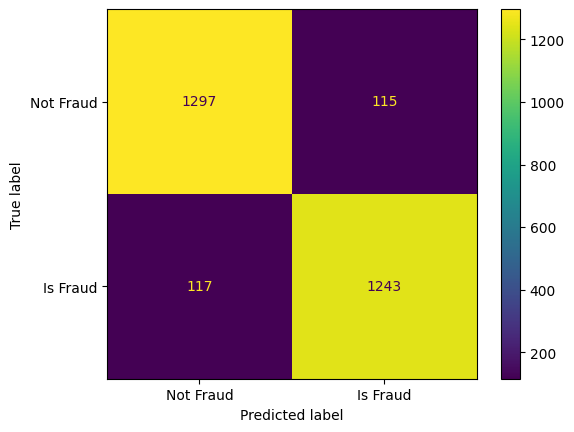

In [ ]:
# Show model prediction errors

plt.figure(figsize=(10,10))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=['Not Fraud', 'Is Fraud'])
disp.plot()

The model performed very well with a 90% accuracy on unseen test data!